# Reproduce the findings from my bachelor thesis
In this notebook I reproduce the results (and plots) of my Bachelor Thesis...

In [1]:
# import section
import numpy as np
import pandas as pd
import xarray as xr

import salem

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import oggm
from oggm import cfg, utils, graphics
from oggm.core import gis, centerlines, climate, massbalance, inversion, flowline

## Run the model

In [2]:
# define parameters
t_star = 1945
bias = 0
prcp_fac = 1.75
glen_a_fac = 1.0

cfg.initialize()
# specify working directory
wdir = '/Users/oberrauch/work/grindelwald/working_directories/reproduce_bac_wdir/'
cfg.PATHS['working_dir'] = wdir

# set border high enough for idealized experiment
cfg.PARAMS['border'] = 20

# using intersects
cfg.PARAMS['use_intersects'] = True

# set climate/massbalance hyper parameters for HistAlp dataset
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = prcp_fac
cfg.PARAMS['temp_melt'] = -1.75

## Preprocessing
# get RGI entity
rgi_id = 'RGI60-11.01270'
rgi_df = utils.get_rgi_glacier_entities([rgi_id], version='6')
rgi_entity = rgi_df.iloc[0]

# specify intersects
cfg.set_intersects_db(utils.get_rgi_intersects_region_file('11'))

# prepare glacier directory
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

# ### GIS
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)

# ### Centerlines
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

## Climate and mass balance parameters
# process the HistAlp climate file
climate.process_histalp_data(gdir)
climate.local_t_star(gdir, tstar=t_star, bias=bias)
climate.mu_star_calibration(gdir)

## Mass balance
# instance mass balance model using the historic climate file
mb_model = massbalance.PastMassBalance(gdir)

# store default values for Glen's A parameter
inv_glen_a = cfg.PARAMS['inversion_glen_a']
glen_a = cfg.PARAMS['glen_a']

# Change the creep parameter
cfg.PARAMS['inversion_glen_a'] = inv_glen_a * glen_a_fac
cfg.PARAMS['glen_a'] = glen_a * glen_a_fac

## Inversion
# run ice thicknes inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

## Dynamic model
# finalize the preprocessing
flowline.init_present_time_glacier(gdir)

## Model
# read needed file
ci = gdir.read_pickle('climate_info')
fls = gdir.read_pickle('model_flowlines')

# now we can use the flowline model
model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                y0=ci['baseline_hydro_yr_0'])

# run model over entire HistAlp period
run_ds, diag_ds = model.run_until_and_store(2014)

2019-06-13 15:58:13: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-06-13 15:58:14: oggm.core.gis: (RGI60-11.01270) define_glacier_region
2019-06-13 15:58:15: oggm.core.gis: (RGI60-11.01270) glacier_masks
2019-06-13 15:58:15: oggm.core.centerlines: (RGI60-11.01270) compute_centerlines
2019-06-13 15:58:16: oggm.core.centerlines: (RGI60-11.01270) initialize_flowlines
2019-06-13 15:58:16: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_line
2019-06-13 15:58:16: oggm.core.centerlines: (RGI60-11.01270) compute_downstream_bedshape
2019-06-13 15:58:16: oggm.core.centerlines: (RGI60-11.01270) catchment_area
2019-06-13 15:58:20: oggm.core.centerlines: (RGI60-11.01270) catchment_intersections
2019-06-13 15:58:20: oggm.core.centerlines: (RGI60-11.01270) catchment_width_geom
2019-06-13 15:58:23: oggm.core.centerlines: (RGI60-11.01270) catchment_width_correction
2019-06-13 15:58:23: oggm.core.climate: (RGI60-11.01270) process_histalp_data
2019-06-13 1

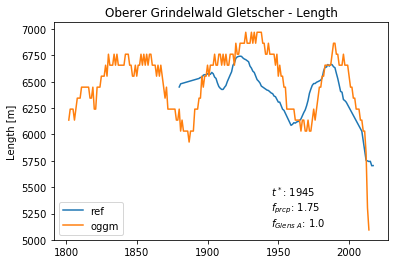

In [3]:
# first look at length
lengt_ref = pd.read_csv('/Users/oberrauch/work/grindelwald/data/length_ref_abs.csv', index_col=0)
lengt_ref.plot(legend=False)
diag_ds.length_m.plot()

# make plot fancier
ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('Length [m]')
ax.set_title('Oberer Grindelwald Gletscher - Length')
handels, _ = ax.get_legend_handles_labels()
ax.legend(handels, ['ref', 'oggm'])

# add parameters as text
ax.text(0.65, 0.05,
        '$t^*$: {}\n$f_{{prcp}}$: {}\n$f_{{Glens\ A}}$: {}'.format(t_star, prcp_fac, glen_a_fac),
        transform=ax.transAxes);

## Make some plots

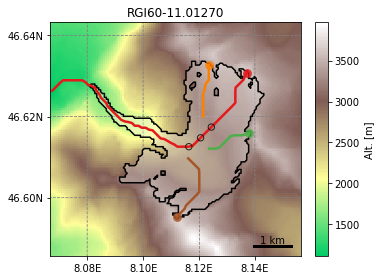

In [4]:
graphics.plot_centerlines(gdir, use_flowlines=True, add_downstream=True)

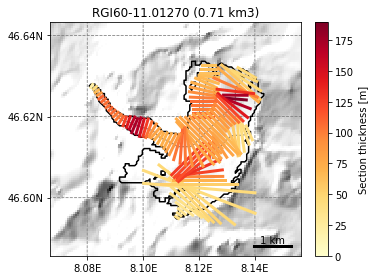

In [5]:
graphics.plot_inversion(gdir)

## Altitude histogram

In [6]:
# Local topography data
fgrid = gdir.get_filepath('gridded_data')
with utils.netCDF4.Dataset(fgrid) as nc:
    topo = nc.variables['topo_smoothed'][:]
    mask = nc.variables['glacier_mask'][:]

In [7]:
# define histogram bins
dist_bins = 100
bins = np.arange(1400, 3601, dist_bins)
bins_ = np.arange(1400+dist_bins/2, 3601-dist_bins/2, dist_bins)

In [8]:
# compute histogram of real glacier based on DEM
dem_count, _ = np.histogram(topo[np.nonzero(mask)], bins=bins, density=True)

In [9]:
# get elevation and corresponding width for all points
# along the flowlines
heights = np.concatenate([fl.surface_h for fl in fls])
widths = np.concatenate([fl.widths_m for fl in fls])

# compute histogram
model_count, _ = np.histogram(heights, weights=widths, bins=bins, density=True)

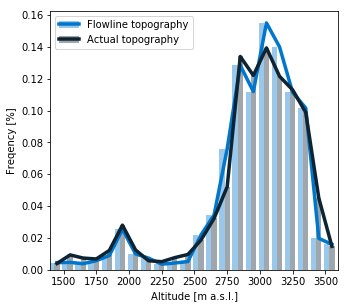

In [10]:
# Plot
c1 = c3 = '#0077CC'
c2 = c4 = '#0F2433'

fig = plt.figure(figsize=[8,6])
ax = fig.add_axes([0.1, 0.1, 0.5, 0.6])
bar_width = dist_bins/2 * 0.8
bar_offset = dist_bins/2 - bar_width
opacity_bar = 0.4
opacity_line = 1
lw = 3.5
lw_ = 0

plt.bar(bins[:-1]+bar_offset, model_count*100, bar_width, 
                        label='Flowline topography', color=c1, 
                        alpha=opacity_bar, lw=lw_)
plt.bar(bins[:-1]+bar_offset+bar_width, dem_count*100, bar_width, 
                     label='Actual topography', 
                     color=c2, alpha=opacity_bar, lw=lw_)

hand, lab = ax.get_legend_handles_labels()

line_1 = plt.plot(bins_, model_count*100, label='Flowline topography',
         color=c3, alpha=opacity_line, lw=lw)
line_2 = plt.plot(bins_, dem_count*100, label='Flowline topography',
         color=c4, alpha=opacity_line, lw=lw)

plt.ylabel('Freqency [%]');
plt.xlabel('Altitude [m a.s.l.]');
plt.xlim([1400,3600])

bar_1 = mpatches.Patch(color=c1, alpha=opacity_bar, lw=lw_)
bar_2 = mpatches.Patch(color=c2, alpha=opacity_bar, lw=lw_)
plt.legend([(line_1[0],bar_1),(line_2[0],bar_2)], ['Flowline topography','Actual topography'], loc=2)

## Mass balance data

In [2]:
# @TODO

## Bed shape

In [3]:
# @TODO

## Locate GPR measurements along flowline

We got two GPR measurements... @TODO

In [11]:
# specify reference location of GPR measurements
lat_ref = np.array([46.61832, 46.61801])
lon_ref = np.array([8.09603, 8.09613])
# create empty container
indices_ref = np.zeros(2)
distances = np.zeros(2)
# get gridpoints of main flowline
gi, gj = fls[-1].line.xy
# convert into WGS84 coordinates
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

# find nearest grid point for poth reference locations
for k in [0,1]:
    # compute straigth line distance
    dist = np.sqrt((lon_ref[k] - lon)**2 + (lat_ref[k] - lat)**2)
    # find lowest distance
    ind_ = dist.argmin()
    # store to container
    indices_ref[k] = int(ind_)
    distances[k] = dist[ind_]
    # user output
    # print('Index {}: Lat {}, Lon {}'.format(indices_ref[k], lat[ind_], lon[ind_]))

# select the closer index of the two
index = int(indices_ref[distances.argmin()])
print('Use index N° {} on the main flow line'.format(index))

Use index N° 43 on the main flow line


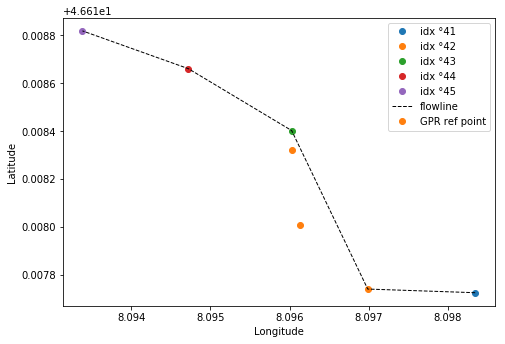

In [12]:
# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# prepare containers for nearby indices
dist = 2
indices = np.arange(index-dist, index+dist+1, 1).astype(int)
n_ind = indices.size
lats = np.zeros(n_ind)
longs = np.zeros(n_ind)
#c = ['C0', 'C3', 'C9']

# iterate over the nearest indices
for i, ind in enumerate(indices):
    ax.plot(lon[ind], lat[ind], label='idx °{}'.format(ind), linestyle='none', marker='o')
    lats[i] = lat[ind]
    longs[i] = lon[ind]
    
# plot flowline
ax.plot(longs, lats, color='k', label='flowline', ls='--', lw=1)
# plot GPR reference locations
plt.plot(lon_ref, lat_ref, label='GPR ref point', linestyle='none', marker='o', color='C1');

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.legend();

361.4687507866718


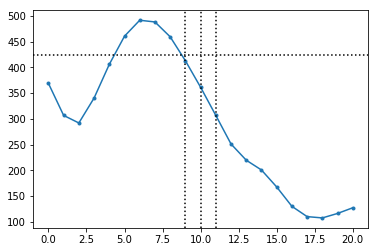

In [13]:
# Plot of the width around the closest point
width_meter = fls[-1].widths_m
plt.plot(width_meter[index-10:index+11], marker='.')
print(width_meter[index])
plt.axhline(425, color='k', linestyle=':')
plt.axvline(10, color='k', linestyle=':')
plt.axvline(11, color='k', linestyle=':')
plt.axvline(9, color='k', linestyle=':')

## Locate cave entrances along the flowline

Here I do the same thing as above, but for the cave entrances.

In [14]:
# specify known information about the cave entrances
cave_names = ['E1', 'E2: BL-1840', 'E3: BL-1750', 'E5', 'E4: BL-1650']
lon_caves = [8.084296603, 8.089826384, 8.089951579, 8.089892598, 8.089909233]
lat_caves = [46.624071981, 46.618130279, 46.618768249, 46.619290335, 46.619587094]
h_caves = [1601, 1885, 1794, 1740, 1697]
h_caves_rel = [np.nan, 0, -88, -145, -188]

# create DataFrame
caves = pd.DataFrame([cave_names, lon_caves, lat_caves, h_caves, h_caves_rel],
                     index=['name', 'lon', 'lat', 'elevation', 'rel_hgt'],
                     columns=[n[:2] for n in cave_names]).T

### Find the closest flowline grid points

In [15]:
# create empty container
nearest_gps = list()
distances_caves = list()
# get gridpoints of main flowline
gi, gj = fls[-1].line.xy
# convert into WGS84 coordinates
lon, lat = gdir.grid.ij_to_crs(np.array(gi), np.array(gj), crs=salem.wgs84)

# find nearest grid point for poth reference locations
for ind, cave in caves.iterrows():
    # compute straigth line distance
    dist = np.sqrt((cave.lon - lon)**2 + (cave.lat - lat)**2)
    # find lowest distance
    nearest_gps.append(dist.argsort()[:2])

# add to DataFrame
caves['nearest_gps'] = nearest_gps

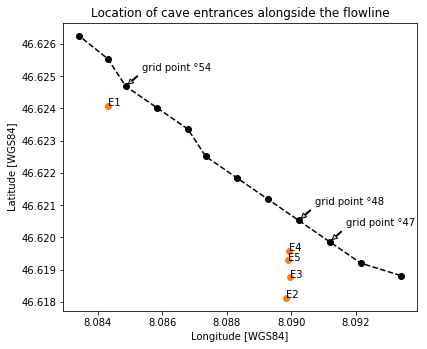

In [16]:
# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# get single nearest grid point
nearest_gps = np.unique([c[0] for c in caves['nearest_gps']])

# plot part of flowline near the cave entrances
dist = 2
idx = slice(min(nearest_gps)-dist, max(nearest_gps)+dist+1)
ax.plot(lon[idx], lat[idx], marker='o', color='k', ls='--')

# plot cave entrances
ax.plot(caves.lon, caves.lat, label='cave entrances', linestyle='none', marker='o', color='C1')
# annotate to cave entrances
for ind, cave in caves.iterrows():
    ax.text(cave.lon, cave.lat, ind)

# annotate the nearest grid points

for gp in nearest_gps:
    ax.annotate('grid point °{}'.format(gp), (lon[gp], lat[gp]), (lon[gp]+0.0005, lat[gp]+0.0005),
                arrowprops=dict(width=1, headlength=5, headwidth=5, shrink=0.15, facecolor='lightgray'))
    
ax.set_aspect('equal')
ax.set_title('Location of cave entrances alongside the flowline')
ax.set_xlabel('Longitude [WGS84]')
ax.set_ylabel('Latitude [WGS84]');

### Find the intersection points

In [4]:
# view caves and there location
caves

NameError: name 'caves' is not defined

In [18]:
# add columns to cave DataFrame
caves['intersection'] = np.NaN
caves['intersection'] = caves['intersection'].astype(object)
caves['fraction_of_flowline_segment'] = np.NaN

# iteravte over all cave entrances
for ind, cave in caves.iterrows():
    # skip cave E1 since it is exactly above GP °54
    if ind == 'E1':
        # add values to DataFrame
        caves.at[ind, 'intersection'] = [lon[54], lat[54]]
        caves.loc[ind, 'fraction_of_flowline_segment'] = 0.0
        continue
    
    print('-----------------------------------------------------------------')
    print(cave.name)
    
    # comput slope (equals dy over dx)
    k_flowline = ((np.diff(lat[cave.nearest_gps])) / (np.diff(lon[cave.nearest_gps])))[0]
    # compute y-axis intersection
    d_flowline = lat[cave.nearest_gps][0] - k_flowline * lon[cave.nearest_gps][0]
    # give some user output
    print('Flowline segment line equation: y = {:.2f}x + {:.2f}'.format(k_flowline, d_flowline))

    # compute line equation for the line normal to the flowline and through cave entrance
    # invert slope to get normal
    k_normal = -1 / k_flowline
    # compute y-axis intersection point 
    d_normal = cave.lat - k_normal * cave.lon
    print('Normal line equation: y = {:.2f}x + {:.2f}'.format(k_normal, d_normal))

    # compute intersection point of flowline and normal
    lon_intersect = ((d_flowline - d_normal) / (k_normal - k_flowline))
    lat_intersect = (k_normal * lon_intersect + d_normal)
    print('The lines intersect at P({:.5f} °E, {:.5f} °N)'.format(lon_intersect, lat_intersect))
    
    # compute distance between cave entrance and flowline
    dist = np.sqrt((lon_intersect - cave.lon)**2 + (lat_intersect - cave.lat)**2)
    print('Distance between cave entrance and flowline {:.5f}°'.format(dist))
    
    # compute distance of intersection point on flowline for linear interpolation
    length_flowline_segment = np.sqrt(((np.diff(lat[cave.nearest_gps]))**2 
                                       + (np.diff(lon[cave.nearest_gps]))**2))[0]
    length_intersection_point = np.sqrt(((lat[min(cave.nearest_gps)] - lat_intersect)**2 
                                         + (lon[min(cave.nearest_gps)] - lon_intersect)**2))
    fraction = length_intersection_point / length_flowline_segment
    print('The intersection point is {:.1f}% on the way between GP °{} and GP °{}'.format(
        fraction*100, min(cave.nearest_gps), max(cave.nearest_gps)))
    
    # add values to DataFrame
    caves.at[ind, 'intersection'] = [lon_intersect, lat_intersect]
    caves.loc[ind, 'fraction_of_flowline_segment'] = fraction

-----------------------------------------------------------------
E2
Flowline segment line equation: y = -0.69x + 52.19
Normal line equation: y = 1.45x + 34.87
The lines intersect at P(8.09107 °E, 46.61994 °N)
Distance between cave entrance and flowline 0.00220°
The intersection point is 11.7% on the way between GP °47 and GP °48
-----------------------------------------------------------------
E3
Flowline segment line equation: y = -0.69x + 52.19
Normal line equation: y = 1.45x + 34.87
The lines intersect at P(8.09086 °E, 46.62009 °N)
Distance between cave entrance and flowline 0.00160°
The intersection point is 33.9% on the way between GP °47 and GP °48
-----------------------------------------------------------------
E5
Flowline segment line equation: y = -0.69x + 52.19
Normal line equation: y = 1.45x + 34.87
The lines intersect at P(8.09058 °E, 46.62028 °N)
Distance between cave entrance and flowline 0.00121°
The intersection point is 63.4% on the way between GP °47 and GP °48
----

In [19]:
# look at DataFrame
caves

,name,lon,lat,elevation,rel_hgt,nearest_gps,intersection,fraction_of_flowline_segment
E1,E1,8.0843,46.6241,1601,NaN,"[54, 55]","[8.084861630778919, 46.62468549315419]",0.000000
E2,E2: BL-1840,8.08983,46.6181,1885,0,"[47, 48]","[8.091073322817378, 46.61994133495398]",0.116769
E3,E3: BL-1750,8.08995,46.6188,1794,-88,"[47, 48]","[8.090860266120083, 46.620088027642055]",0.338505
E5,E5,8.08989,46.6193,1740,-145,"[48, 47]","[8.090576392309446, 46.62028347896036]",0.633943
E4,E4: BL-1650,8.08991,46.6196,1697,-188,"[48, 47]","[8.090449064452196, 46.62037114607378]",0.766458


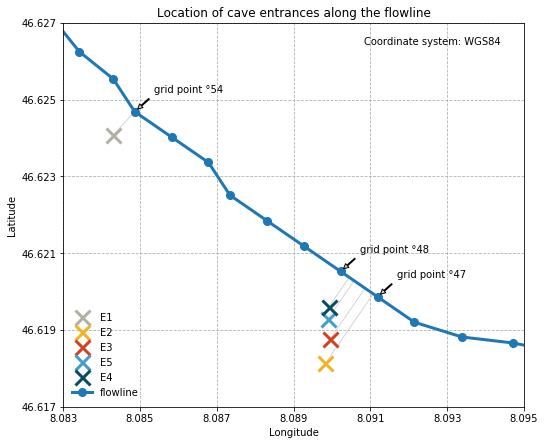

In [199]:
# define colors for caves
colors_cave = ['#B2B0A5', '#F0B323', '#D14124', '#439CCC', '#084C61']
caves['color'] = colors_cave

# create figure and add axes
fig = plt.figure(figsize=[8,8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])


for ind, cave in caves.iterrows():
    # plot the normals between cave entrances and flowline
    x = [cave.lon, cave.intersection[0]]
    y = [cave.lat, cave.intersection[1]]
    ax.plot(x, y, c='0.8', lw=0.8)
    # plot cave entrances
    ax.plot(cave.lon, cave.lat, marker='x', linestyle='none', label=ind,
             color=cave.color, markersize=15, markeredgewidth=3)

    
# plot flowline
ax.plot(lon, lat, linestyle='-', marker='o', lw=3, markersize='8', label='flowline')    

# annotate grid points
for gp in nearest_gps:
    ax.annotate('grid point °{}'.format(gp), (lon[gp], lat[gp]), (lon[gp]+0.0005, lat[gp]+0.0005),
                arrowprops=dict(width=1, headlength=5, headwidth=5, shrink=0.15, facecolor='lightgray'))


# set figure section and aspect
xlim = [8.083, 8.093]
ylim = [46.617,46.626]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal')
# show grid
ax.grid(ls='--')

# ticks and ticklabels
d_ticks = 0.002
ax.set_xticks(np.arange(xlim[0], xlim[1]+d_ticks, d_ticks))
ax.set_yticks(np.arange(ylim[0], ylim[1]+d_ticks, d_ticks))

# labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Location of cave entrances along the flowline')

# add info about coordinate system
ax.text(0.95, 0.95, 'Coordinate system: WGS84', va='center', ha='right', transform=ax.transAxes)

# add legend
ax.legend(loc=3, numpoints=1, frameon=False)

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/caves_location.pdf'
plt.savefig(path, bbox_inches='tight')

## Get glacier thicknes near cave entrances

In [22]:
# instance a new model
model = flowline.FluxBasedModel(fls, mb_model=mb_model,
                                y0=ci['baseline_hydro_yr_0'])

In [23]:
# create xarray Dataset with coordinates
ds = xr.Dataset()
# add coordinates
years = np.arange(ci['baseline_hydro_yr_0'], ci['baseline_hydro_yr_1']+1)
ds.coords['year'] = ('year', years)
grid_points = np.arange(model.fls[-1].nx)
ds.coords['grid_point'] = ('grid_point', grid_points)

# get shape of Dataset
shape = [dim for dim in ds.dims.values()]
# create dummy matrix, filled with NaN
dummy = np.zeros(shape) * np.NaN

# add variables and respective attributes
ds['bed_h'] = (['grid_point','year'], dummy.copy())
ds['surface_h'] = (['grid_point','year'], dummy.copy())
ds['fl_width'] = (['grid_point','year'], dummy.copy())

In [24]:
# run model for whole HISTALP period (1802 - 2014)
for y in years:
    # let model run for one year
    model.run_until(y)
    # get main model flowline
    fl = model.fls[-1]
    # get parameters of interest
    ds['bed_h'].loc[{'year': y}] = fl.bed_h
    ds['surface_h'].loc[{'year': y}] = fl.surface_h
    ds['fl_width'].loc[{'year': y}] = fl.widths_m

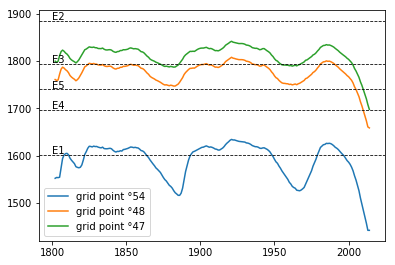

In [25]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

for gp in [54, 48, 47]:
    # plot surface height
    ax.plot(ds['year'], ds['surface_h'].sel(grid_point=gp), label='grid point °{}'.format(gp))
    
ax.legend()
    
for ind, cave in caves.iterrows():
    ax.axhline(cave.elevation, ls='--', lw=0.8, c='k')
    ax.text(1800, cave.elevation+2, ind)

Since the cave entrances are between grid points I'll interpolate the surface elevation and evaluate it at the respective location.

In [63]:
def interp_between_grid_points(ds, gp0, gp1, fraction):
    """Aux function to facilitate computation of ice thickness near cave entrances."""
    return ds.sel(grid_point=gp0) * (1 - fraction) + ds.sel(grid_point=gp1) * fraction

In [64]:
# add columns with information about ice thickness to cave DataFrame
caves['surface_h'] = np.NaN
caves['surface_h'] = caves['surface_h'].astype(object)
caves['bed_h'] = np.NaN
caves['bed_h'] = caves['bed_h'].astype(object)

# iterate over all caves
for ind, cave in caves.iterrows():
    # compute ice thickness near cave entrance (linear interpolation)
    gp = np.sort(cave.nearest_gps)
    ds_interp = interp_between_grid_points(ds, gp[0], gp[1], cave.fraction_of_flowline_segment)
    caves.at[ind, 'surface_h'] = ds_interp['surface_h'].to_dataframe()
    caves.at[ind, 'bed_h'] = ds_interp['bed_h'].to_dataframe()

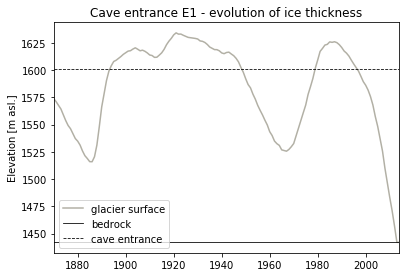

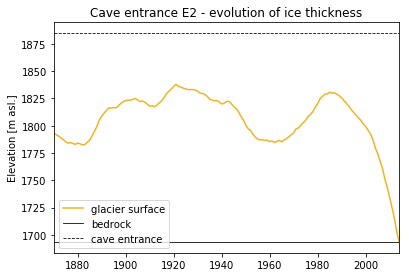

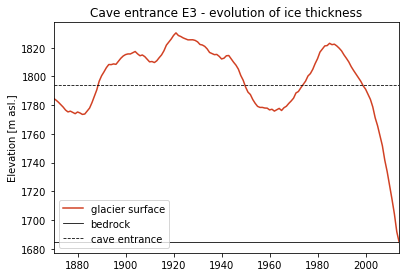

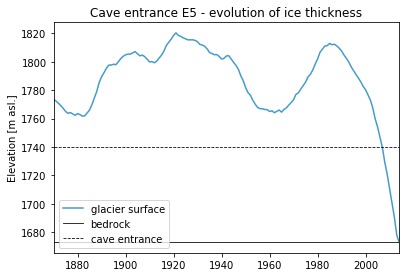

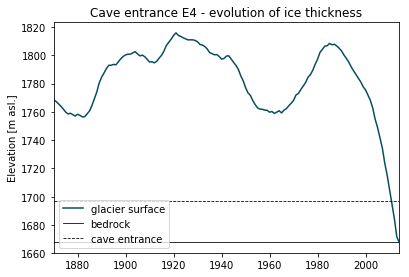

In [31]:
# make some plots
for ind, cave in caves.iterrows():
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    c = 'C0'
    # plot thickness evolution over time
    ax.plot(cave.surface_h, c=cave.color, label='glacier surface')
    # add bedrock
    ax.plot(cave.bed_h, c='k', lw=0.8, label='bedrock')
    # mark elevation of cave entrance
    ax.axhline(cave.elevation, c='k', ls='--', lw=0.8, label='cave entrance')
    
    # labels, title, legend
    ax.set_ylabel('Elevation [m asl.]')
    ax.set_title('Cave entrance {} - evolution of ice thickness'.format(ind))
    ax.legend(loc=3)
    
    # crop spinup period, before 1850+
    ax.set_xlim([1870, 2014])

In [33]:
# read observations made by Marc
path = '/Users/oberrauch/Dropbox/Bachelor_Grindelwald/Daten von Marc/glacier_elevation_observed.csv'
glacier_elev_obs = pd.read_csv(path, delimiter='\t', header=None, index_col=0)
glacier_elev_obs.columns = ['elevation', 'elev_error', 'comment']
glacier_elev_obs.index.name = 'year' 
glacier_elev_obs

,elevation,elev_error,comment
year,,,
2000,1870.0,20.0,glacier moraine below E2 ????
2005,1795.0,5.0,glacier at E3
2006,NaN,NaN,n.d.
2007,NaN,NaN,E4 completely closed
2008,1760.0,10.0,ca. 30 m below E3; E4 closed but first air dra...
2009,NaN,NaN,n.d.
2010,1740.0,5.0,glacier at E5; E4 shows first daylight
2011,1710.0,10.0,E4 open but glacier still above
2012,1690.0,5.0,glacier ca. 10 m below E4


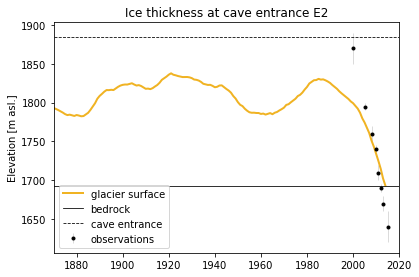

In [34]:
# select entrances
ind = 'E2'
cave = caves.loc[ind]

# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
c = 'C0'
# plot thickness evolution over time
ax.plot(cave['surface_h'], c=cave.color, label='glacier surface', lw=2)
# add bedrock
ax.axhline(cave['bed_h'].iloc[0].values, c='k', lw=0.8, label='bedrock')
# mark elevation of cave entrance
ax.axhline(cave.elevation, c='k', ls='--', lw=0.8, label='cave entrance')

# overlay observations
ax.errorbar(glacier_elev_obs.index, glacier_elev_obs['elevation'], marker='.', ls='None', color='k',
             yerr=glacier_elev_obs['elev_error'], ecolor='lightgray', elinewidth=0.8, label='observations')

# labels, title, legend
ax.set_ylabel('Elevation [m asl.]')
ax.set_title('Ice thickness at cave entrance {}'.format(ind))
ax.legend(loc=3)

# crop spinup period, before 1850+
ax.set_xlim([1870, 2020])

folder = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/'
fname = 'ice_thicknes_{}.pdf'.format(ind.lower())
path = folder + fname
plt.savefig(path, bbox_inches='tight')

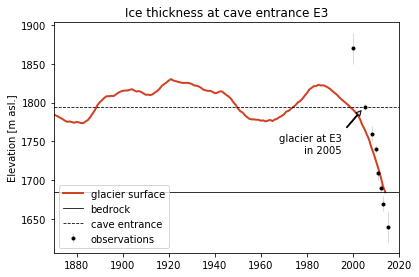

In [35]:
# select entrances
ind = 'E3'
cave = caves.loc[ind]

# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
c = 'C0'
# plot thickness evolution over time
ax.plot(cave['surface_h'], c=cave.color, label='glacier surface', lw=2)
# add bedrock
ax.axhline(cave['bed_h'].iloc[0].values, c='k', lw=0.8, label='bedrock')
# mark elevation of cave entrance
ax.axhline(cave.elevation, c='k', ls='--', lw=0.8, label='cave entrance')

# overlay observations
ax.errorbar(glacier_elev_obs.index, glacier_elev_obs['elevation'], marker='.', ls='None', color='k',
             yerr=glacier_elev_obs['elev_error'], ecolor='lightgray', elinewidth=0.8, label='observations')

# labels, title, legend
ax.set_ylabel('Elevation [m asl.]')
ax.set_title('Ice thickness at cave entrance {}'.format(ind))
ax.legend(loc=3)

# crop spinup period, before 1850+
ax.set_xlim([1870, 2020])

# annotate observation
ax.annotate('glacier at E3\nin 2005', xy=(2005, glacier_elev_obs.loc[2005, 'elevation']),
            xytext=(1995, glacier_elev_obs.loc[2005, 'elevation']-60), ha='right',
            arrowprops=dict(width=0.8, headlength=5, headwidth=5, shrink=0.15, facecolor='lightgray'))

folder = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/'
fname = 'ice_thicknes_{}.pdf'.format(ind.lower())
path = folder + fname
plt.savefig(path, bbox_inches='tight')

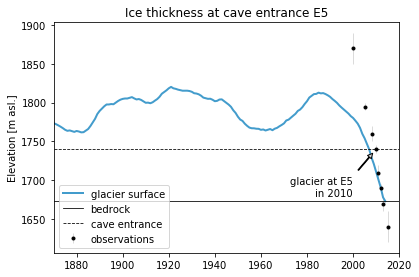

In [36]:
# select entrances
ind = 'E5'
cave = caves.loc[ind]

# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
c = 'C0'
# plot thickness evolution over time
ax.plot(cave['surface_h'], c=cave.color, label='glacier surface', lw=2)
# add bedrock
ax.axhline(cave['bed_h'].iloc[0].values, c='k', lw=0.8, label='bedrock')
# mark elevation of cave entrance
ax.axhline(cave.elevation, c='k', ls='--', lw=0.8, label='cave entrance')

# overlay observations
ax.errorbar(glacier_elev_obs.index, glacier_elev_obs['elevation'], marker='.', ls='None', color='k',
             yerr=glacier_elev_obs['elev_error'], ecolor='lightgray', elinewidth=0.8, label='observations')

# labels, title, legend
ax.set_ylabel('Elevation [m asl.]')
ax.set_title('Ice thickness at cave entrance {}'.format(ind))
ax.legend(loc=3)

# crop spinup period, before 1850+
ax.set_xlim([1870, 2020])

# annotate observation
# 2010 	1740.0 	5.0 	glacier at E5; E4 shows first daylight
ax.annotate('glacier at E5\nin 2010', xy=(2010, glacier_elev_obs.loc[2010, 'elevation']),
            xytext=(2000, glacier_elev_obs.loc[2010, 'elevation']-60), ha='right',
            arrowprops=dict(width=0.8, headlength=5, headwidth=5, shrink=0.15, facecolor='lightgray'))

folder = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/'
fname = 'ice_thicknes_{}.pdf'.format(ind.lower())
path = folder + fname
plt.savefig(path, bbox_inches='tight')

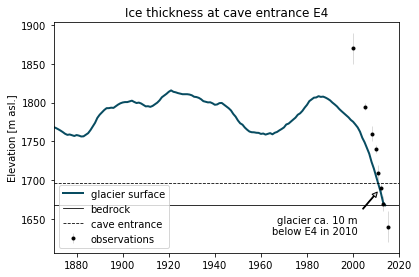

In [37]:
# select entrances
ind = 'E4'
cave = caves.loc[ind]

# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
c = 'C0'
# plot thickness evolution over time
ax.plot(cave['surface_h'], c=cave.color, label='glacier surface', lw=2)
# add bedrock
ax.axhline(cave['bed_h'].iloc[0].values, c='k', lw=0.8, label='bedrock')
# mark elevation of cave entrance
ax.axhline(cave.elevation, c='k', ls='--', lw=0.8, label='cave entrance')

# overlay observations
ax.errorbar(glacier_elev_obs.index, glacier_elev_obs['elevation'], marker='.', ls='None', color='k',
             yerr=glacier_elev_obs['elev_error'], ecolor='lightgray', elinewidth=0.8, label='observations')

# labels, title, legend
ax.set_ylabel('Elevation [m asl.]')
ax.set_title('Ice thickness at cave entrance {}'.format(ind))
ax.legend(loc=3)

# crop spinup period, before 1850+
ax.set_xlim([1870, 2020])

# annotate observation
ax.annotate('glacier ca. 10 m\nbelow E4 in 2010', xy=(2012, glacier_elev_obs.loc[2012, 'elevation']),
            xytext=(2002, glacier_elev_obs.loc[2012, 'elevation']-60), ha='right',
            arrowprops=dict(width=0.8, headlength=5, headwidth=5, shrink=0.15, facecolor='lightgray'))

folder = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/'
fname = 'ice_thicknes_{}.pdf'.format(ind.lower())
path = folder + fname
plt.savefig(path, bbox_inches='tight')

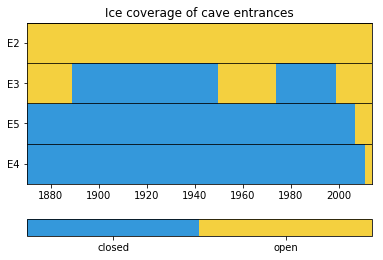

In [38]:
from matplotlib import colors as mcolors

# create matrix
open_matrix = [(cave.surface_h <= cave.elevation).T.values.tolist() for ind, cave in caves.loc['E2':].iterrows()]
open_matrix = np.reshape(np.array(open_matrix), (4, len(cave.surface_h)))[::-1]
open_matrix = open_matrix.astype(int)

# create boolean colormap
cmap = mcolors.ListedColormap(['#3498db', '#f4d03f'])

# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# create gridpoints
cave_idx = np.array([0, 1, 2, 3, 4])
xx, yy = np.meshgrid(cave.surface_h.index, cave_idx)

# plot matrix
cax = ax.pcolormesh(xx, yy, open_matrix, cmap=cmap, edgecolor='None', linestyle='-', lw=1)

# add lines to seperate the different entrances
for hline in cave_idx:
    ax.axhline(hline, c='k', lw=0.8)

# crop spinup period, before 1850+
ax.set_xlim([1870, 2014])
    
# adjust labels
ax.set_yticks(np.linspace(0.5, 3.5, 4))
ax.set_yticklabels(caves.index[:0:-1])

# add colorbar
cbar = plt.colorbar(cax, ticks=[0.25, 0.75], orientation='horizontal', drawedges=False)
cbar.set_ticklabels(['closed', 'open'])

# title
ax.set_title('Ice coverage of cave entrances')

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/caves_open.pdf'
plt.savefig(path, bbox_inches='tight')

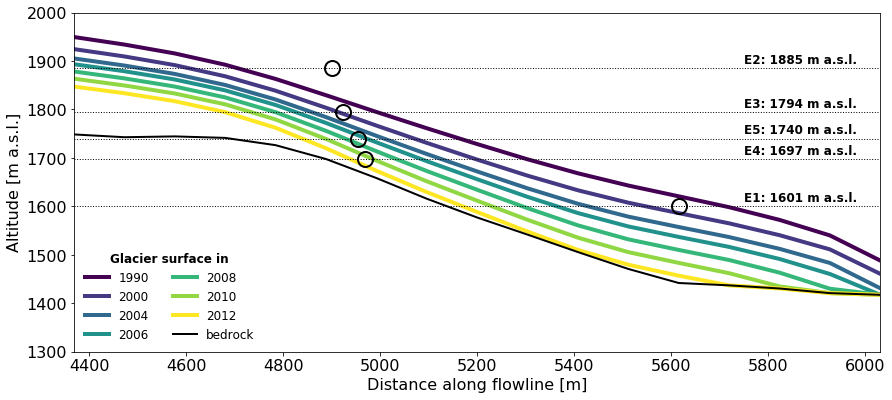

In [198]:
# create figure and add axes
fig = plt.figure(figsize=[14, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# get main flowline
fl = fls[-1]
# define indices to plot
grid_points = np.arange(42, 59)
# define x index
x = grid_points * fl.map_dx * fl.dx
# specify years which I want to plot
years_plot = np.array([1990, 2000, 2004, 2006, 2008, 2010, 2012])

# get colormap
cmap = plt.get_cmap('viridis', years_plot.size)
#cmap = mcolors.ListedColormap(['#DB504A', '#30BCED', '#303036', '#E3B505', '#0B7A75', '#BA3B46', '#6369D1'])

# plot glacier surface for different years
for i, year in enumerate(years_plot):
    surf_h = ds['surface_h'].sel(year=year, grid_point=grid_points)
    ax.plot(x, surf_h, color=cmap(i), lw=4)
    
# plot bedrock
ax.plot(x, fl.bed_h[grid_points], color='k', lw=2, label='bedrock')

# plot cave entrances
entrance_x = [min(cave.nearest_gps) + cave.fraction_of_flowline_segment for _, cave in caves.iterrows()]
entrance_x = np.array(entrance_x) * fl.map_dx * fl.dx
ax.plot(entrance_x, caves.elevation, linestyle='none', marker='o', markersize=15, color='none',
     markeredgecolor='k', markeredgewidth=2)

for ind, cave in caves.iterrows():
    # add auxiliary lines at height of cave entrances
    ax.axhline(cave.elevation, color='k', linestyle=':', lw=1)
    # plot name and elevation of cave entrances
    ax.text(5750, cave.elevation + 10,
            '{}: {} m a.s.l.'.format(ind, cave.elevation),
            fontsize=12, fontweight='bold')

# adjust plot
ax.set_xlim([min(x), max(x)])
ax.set_ylim([1300, 2000])
ax.set_aspect('equal', adjustable='box')

# labels
ax.set_xlabel('Distance along flowline [m]', fontsize=16)
ax.set_ylabel('Altitude [m a.s.l.]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

# legend
handels, _ = ax.get_legend_handles_labels()
labels = np.append(years_plot, 'bedrock')
legend_title = 'Glacier surface in'
leg = ax.legend(handels[:-1], labels, loc=3, ncol=2,
                title=legend_title, fontsize=12, frameon=False)
leg.get_title().set_fontsize(12)
leg.get_title().set_fontweight('bold')

path = '/Users/oberrauch/work/grindelwald/figures/repoduce_bac/glacier_cross_section.pdf'
plt.savefig(path, bbox_inches='tight')

In [123]:
for i, year in enumerate(years_plot):
    print(cmap(i))

(0.267004, 0.004874, 0.329415, 1.0)
(0.278826, 0.17549, 0.483397, 1.0)
(0.229739, 0.322361, 0.545706, 1.0)
(0.172719, 0.448791, 0.557885, 1.0)
(0.127568, 0.566949, 0.550556, 1.0)
(0.157851, 0.683765, 0.501686, 1.0)
(0.369214, 0.788888, 0.382914, 1.0)
(0.678489, 0.863742, 0.189503, 1.0)


In [58]:
diag_ds

<xarray.Dataset>
Dimensions:         (time: 213)
Coordinates:
  * time            (time) float64 1.802e+03 1.803e+03 1.804e+03 1.805e+03 ...
    hydro_year      (time) int64 1802 1803 1804 1805 1806 1807 1808 1809 ...
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    calendar_year   (time) int64 1801 1802 1803 1804 1805 1806 1807 1808 ...
    calendar_month  (time) int64 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...
Data variables:
    volume_m3       (time) float64 7.109e+08 7.006e+08 6.963e+08 6.93e+08 ...
    area_m2         (time) float64 9.032e+06 9.04e+06 9.044e+06 9.051e+06 ...
    length_m        (time) float64 6.136e+03 6.24e+03 6.24e+03 6.24e+03 ...
    ela_m           (time) float64 3.154e+03 2.997e+03 3.018e+03 2.814e+03 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.2.dev25+g8b213af
    calendar:       365-day no leap
    creation_date:  2019-06-13 13:58:26

In [ ]:
# create figure and add axes
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

x_t = 5165
for i, h_ in enumerate(height_cave_ref):
    if not np.isnan(h_):
        ax.axhline(h_, color='k', linestyle=':', lw=1)
        ax.text(x_t, h_+10, '{}: {} m a.s.l.'.format(caves[i+1][:2], int(h_)), fontsize=12, fontweight='bold')

ind=np.arange(40,60)
x = ind*u_fl.map_dx*u_fl.dx
years_plot = np.array([1980, 1990, 2000, 2004, 2006, 2008, 2010, 2012])


col_map = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=0, vmax=years_plot.size)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=col_map)

# plot bedrock
bed_h_ = bed_h[ind]
ax.plot(x, bed_h_, color='k', lw=3)

c_count = 0
for i,y in enumerate(years_height):
    if y in years_plot:
        col = scalarMap.to_rgba(c_count)
        c_count += 1
        surf_h_ = surf_h[i][ind]
        ind_terminus = np.where(bed_h_ == surf_h_)[0]
        if ind_terminus.any():
            surf_h_[ind_terminus[0]+1:] = np.nan
        ax.plot(x, surf_h_, color=col, label=y, lw=3)

l_title = 'Glacier surface in'
leg_1 = ax.legend(loc=3, ncol=2, title=l_title, fontsize=12, frameon=False)
leg_1.get_title().set_fontsize(12)
leg_1.get_title().set_fontweight('bold')

m_ = u'\u25CC'
x_caves = (f_s + [x[0] for x in inds] + [0,0.5,1,1.5,2])*u_fl.map_dx*u_fl.dx
for i in range(1,n_caves):
    ax.text(x_caves[i], h_caves[i], m_, fontsize=37, fontname='Arial', va='center', ha='center', 
            color='0', weight='bold')

x_caves = (f_s + [x[0] for x in inds])*u_fl.map_dx*u_fl.dx
plt.plot(x_caves, h_caves, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)

# costume legend for caves
x_hand = 4100
y_hand = 1500
d_y_leg = 50
d_x_leg = 30

ax.plot(x_hand, y_hand, linestyle='none', marker='o', markersize=15, color='none',
         markeredgecolor='k', markeredgewidth=2)
ax.text(x_hand+d_x_leg, y_hand, 'from GPS', fontsize=12, va='center')
ax.text(x_hand-1, y_hand-d_y_leg, m_, fontsize=37, fontname='Arial', va='center', ha='center', 
            color='0', weight='bold')
ax.text(x_hand+d_x_leg, y_hand-d_y_leg, 'suggested', fontsize=12, va='center')
# legend title
ax.text(x_hand-15, y_hand+d_y_leg+5, 'position of entraces', fontsize=12, va='center', weight='bold')



ax.set_xticks(np.arange(3000,6000,250))
ax.set_xlim([x[0], x[-1]])
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('Distance along flowline [m]')
ax.set_ylabel('Altitude [m a.s.l.]')